In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
int_dir = os.path.join(data_dir,'analysis','interim')
fig_dir = os.path.join(proj_dir,'reports','figures')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress
from tools.cartesian_grid_2d import cartesian_grid_2d
from tools.uvp_masks import uvp_masks
from tools.calc_z import calc_z

grid_path = os.path.join(int_dir,'grd2_dV.nc')
m_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_m.nc')
#temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp.nc')
#zeta_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_zeta.nc')
shelves_path = os.path.join(data_dir,'analysis','interim','shelves2.npy')
sec_path = os.path.join(int_dir,'mask_sector2.npy')
shelf_sec_path = os.path.join(int_dir,'mask_shelf_sector2.npy')

In [2]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:47021 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [2]:
grd = xr.open_dataset(grid_path)
m = xr.open_dataset(m_path).m
#temp = xr.open_dataset(temp_path,chunks={'xi_rho':1000,'eta_rho':1000,'s_rho':2,'ocean_time':1}).temp
#temp = xr.open_dataset(temp_path).temp
#zeta = xr.open_dataset(zeta_path).zeta

shelves = np.load(shelves_path).item()
mask_sector = np.load(sec_path).item()
mask_sector_shelf = np.load(shelf_sec_path).item()

In [31]:
mask_depth_path = os.path.join(int_dir,'mask_depth_2.npy')
mask_depth = np.load(mask_depth_path).item()

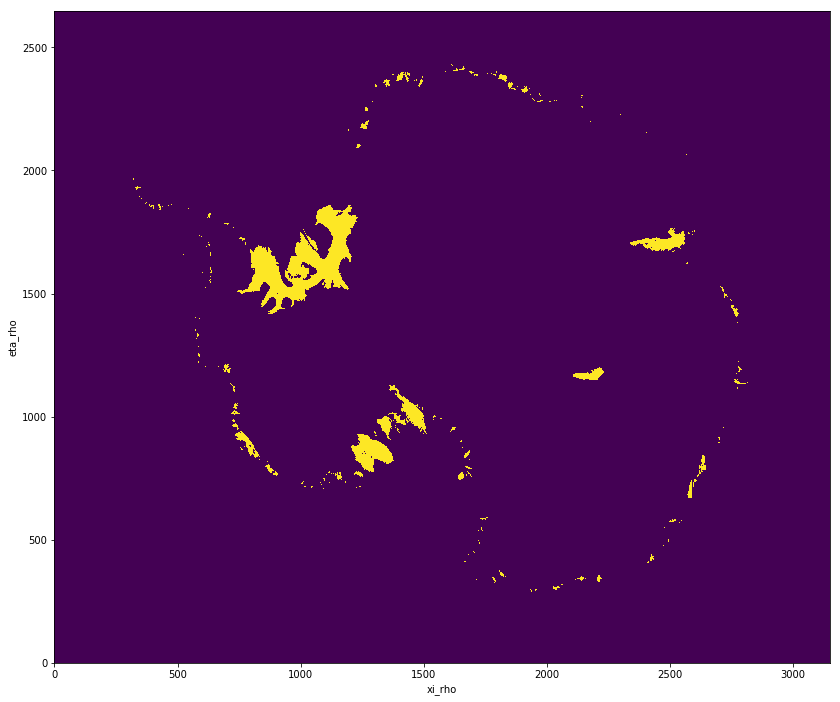

In [33]:
%matplotlib inline

plt.close()
fig,ax = plt.subplots(figsize=(15,12))
mask_depth['deep'].plot(ax=ax,add_colorbar=False)
ax.set_aspect('equal')
#ax.set_axes('off')
plt.show()

In [71]:
s2a = 365*24*3600

dA = 1/(grd.pn*grd.pm)

melt={}

for sec_key,sec_mask in mask_sector.items():
    print(sec_key)
    melt[sec_key] = {}
        
    for depth_key,depth_mask in mask_depth.items():        
        print(depth_key)
        mask = depth_mask & sec_mask
        
        weights = dA.where(mask)/dA.where(mask).sum()
        
        melt[sec_key][depth_key] = m[:,0,0]
    
        for i,time in log_progress(enumerate(m.ocean_time),every=2,name='time steps'): 
            melt[sec_key][depth_key][i] = (m[i]*weights).sum(['xi_rho','eta_rho'])*s2a

dict_out_path = os.path.join(int_dir,'depth_melt_evo.npy')
np.save(dict_out_path,melt)

Total Antarctica
all


shallow


mid


deep


Western East Antarctica
all


shallow


mid


deep


Amery/Prydz Bay
all


shallow


mid


deep


Sabrina Coast/Aurora subglacial basin
all


shallow


mid


deep


George V Coast/Wilkes subglacial basin
all


shallow


mid


deep


Ross Sea
all


shallow


mid


deep


Amundsen Sea
all


shallow


mid


deep


Bellingshausen Sea
all


shallow


mid


deep


Weddell Sea
all


shallow


mid


deep


In [45]:
test = {k: mask_sector[k] for k in ('Weddell Sea','Ross Sea')}

In [65]:
melt_dict = np.load(os.path.join(int_dir,'shallow_melt_evo.npy')).item()
shallow_melt = melt_dict['shallow']
deep_melt = melt_dict['deep']

In [22]:
surface_depth = -100
low_thermo_depth = -400

shallow_temp = {}
deep_temp = {}

for key,mask_sec in mask_sector_shelf.items():

    print(key)
    mask = mask_sec & (grd.zice == 0.0)
  
    shallow_temp[key] = temp[:,0,0,0].load()
    deep_temp[key] = temp[:,0,0,0].load()

    dx, dy = cartesian_grid_2d(grd.lon_u,grd.lat_u,grd.lon_v,grd.lat_v)
    dx = xr.DataArray(dx,dims=('eta_rho','xi_rho')).where(mask,drop=True)
    dy = xr.DataArray(dy,dims=('eta_rho','xi_rho')).where(mask,drop=True)  
    
    h = grd.h.where(mask,drop=True)
    zice = grd.zice.where(mask,drop=True)
    
    for i,time in log_progress(enumerate(temp.ocean_time),every=2,name='time steps'):
        
        zeta_i = zeta[i].where(mask,drop=True)
        
        z, sc_r, Cs_r = calc_z(h, zice, 7, 8, 250, 31, zeta_i)
        z_edges = np.zeros((31+1, h.eta_rho.size, h.xi_rho.size))
        z_edges[1:-1,:,:] = 0.5*(z[0:-1,:,:] + z[1:,:,:])
        z_edges[-1,:,:] = zice[:,:]
        z_edges[-1,:,:] += zeta_i[:,:]
        z_edges[0,:,:] = 2*z[0,:,:] - z_edges[1,:,:]
        dz = z_edges[1:,:,:] - z_edges[0:-1,:,:]
        z = xr.DataArray(z,dims=('s_rho','eta_rho','xi_rho'))
        dz = xr.DataArray(dz,dims=('s_rho','eta_rho','xi_rho'))

        dV = dz*dx*dy
                                                
        mask_shallow = z >= surface_depth
        mask_deep = z < low_thermo_depth
        
        weights_shallow = dV.where(mask_shallow)/dV.where(mask_shallow).sum()
        weights_deep = dV.where(mask_deep)/dV.where(mask_deep).sum()
        
        shallow_temp[key][i] = (temp[i].where(mask,drop=True).where(mask_shallow)*weights_shallow).sum().load()
        deep_temp[key][i] = (temp[i].where(mask,drop=True).where(mask_deep)*weights_deep).sum().load()

dict_out_path = os.path.join(int_dir,'shallow_temp_evo.npy')
np.save(dict_out_path,{'shallow':shallow_temp,'deep':deep_temp})

Total Antarctica


Western East Antarctica


Amery/Prydz Bay


Sabrina Coast/Aurora subglacial basin


George V Coast/Wilkes subglacial basin


Ross Sea


Amundsen Sea


Bellingshausen Sea


Weddell Sea


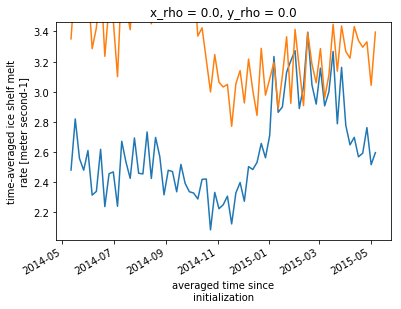

In [21]:
sm = shallow_melt['Amundsen Sea']
dm = deep_melt['Amundsen Sea']

plt.close()
fig,ax1 = plt.subplots()
(sm).plot(ax=ax1)
(dm).plot(ax=ax1)
#ax2 = ax1.twinx()
#shallow_temp['Total Antarctica'].plot(ax=ax2)
plt.show()

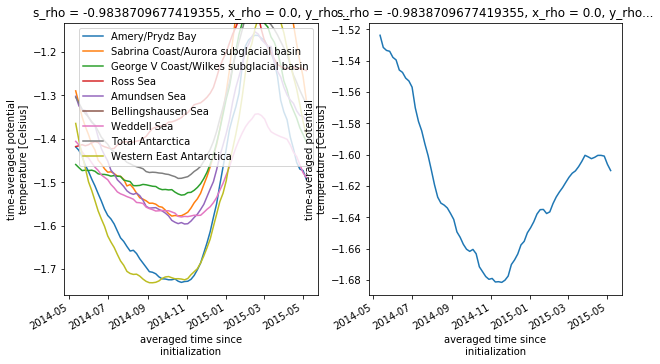

In [58]:
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(10,5))
ax1,ax2 = axes.flatten()
for key,data in shallow_temp.items():
    data.plot(ax=ax1,label=key)
ax1.legend()
#ax1.set_ylim(0,8)

for key,data in deep_temp.items():
    data.plot(ax=ax2,label=key)
#ax2.set_ylim(0,8)
plt.show()


In [104]:
ticks[0::6]

array([ 5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5])

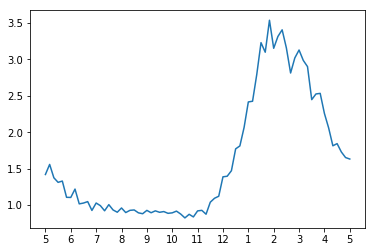

In [105]:
plt.close()
fig,ax1 = plt.subplots()
ax1.plot(shallow_melt['Total Antarctica'])
ax1.set_xticks(np.arange(0,73,6))
ax1.set_xticklabels(ticks[0::6])
plt.show()

In [12]:
melt = np.load(os.path.join(int_dir,'depth_melt_evo.npy')).item()
temp_dict = np.load(os.path.join(int_dir,'shallow_temp_evo.npy')).item()
shallow_temp = temp_dict['shallow']
deep_temp=temp_dict['deep']

In [14]:
for dic in [melt,shallow_temp,deep_temp]:
    dic["Sabrina Coast"] = dic.pop('Sabrina Coast/Aurora subglacial basin')
    dic['George V Coast'] = dic.pop('George V Coast/Wilkes subglacial basin')
    dic['Prydz Bay'] = dic.pop('Amery/Prydz Bay')

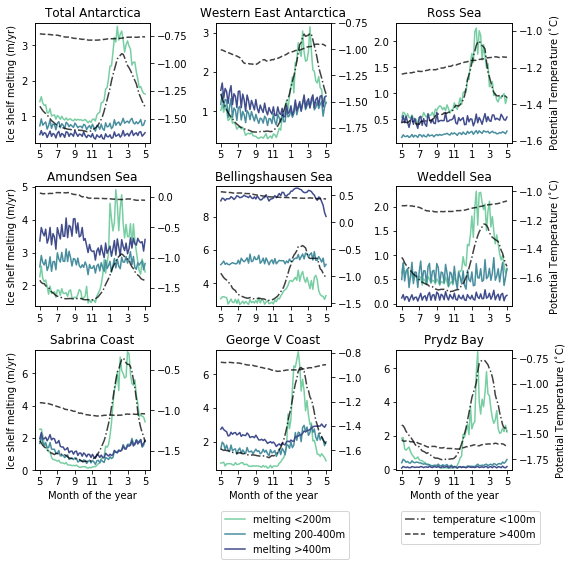

In [34]:
cmap=ocm.deep
colors=(cmap(0.25),cmap(0.5),cmap(0.75))

plt.close()
fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(8,8))

for ax1,(sec_key,sec_melt) in zip(axes.flatten(),melt.items()):
    ml1 = ax1.plot(sec_melt['shallow'],color=colors[0],label='melting <200m')
    ml2 = ax1.plot(sec_melt['mid'],color=colors[1],label='melting 200-400m')
    ml3 = ax1.plot(sec_melt['deep'],color=colors[2],label='melting >400m')
    
    max_val = sec_melt['shallow'].max()
    min_val = sec_melt['shallow'].min()
    for depth_key,depth_data in sec_melt.items():
        max_val = max(max_val,depth_data.max())
        min_val = min(min_val,depth_data.min())
    
    y_max = max_val+0.1
    y_min = min_val-0.1
    ax1.set_ylim(y_min,y_max)
    ax1.set_xticks(np.arange(0,73,12))
    ax1.set_xticklabels(ticks[0::12])
    ax1.set_title(sec_key)
    
    ax2=ax1.twinx()
    tl1 = ax2.plot(shallow_temp[sec_key],linestyle='-.',alpha=0.75,color='k',label='temperature <100m')
    tl2 = ax2.plot(deep_temp[sec_key],linestyle='--',alpha=0.75,color='k',label='temperature >400m')
    y_min = min(deep_temp[sec_key].min(),shallow_temp[sec_key].min())-0.1
    y_max = max(deep_temp[sec_key].max(),shallow_temp[sec_key].max())+0.1
    ax2.set_ylim(y_min,y_max)
    
    if sec_key in ['Prydz Bay','Ross Sea','Weddell Sea']:
        ax2.set_ylabel('Potential Temperature ($^{\circ}$C)')
    
    if sec_key == 'George V Coast':
        ax1.legend(loc='upper left',bbox_to_anchor=(0.0,-0.3))
    if sec_key == 'Prydz Bay':
        ax2.legend(loc='upper left',bbox_to_anchor=(0.0,-0.3))
    
for ax in axes.flatten()[6:]:
    ax.set_xlabel('Month of the year')
for ax in axes.flatten()[[0,3,6]]:
    ax.set_ylabel('Ice shelf melting (m/yr)')

plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'ismr_temp_depths.png'),transparent=True,dpi=300)
plt.show()


In [68]:
max_val = 0
for depth_key,depth_data in sec_melt.items():
    max_val = max(max_val,depth_data.max())
max_val

<xarray.DataArray 'm' ()>
array(2.318714)
Coordinates:
    x_rho    float64 ...
    y_rho    float64 ...

In [4]:
mask_shallow_WEA = (grd.z >= -200) & (mask_sector_shelf['Western East Antarctica'] == 1)
xi_min = grd.xi_rho.where(mask_shallow_WEA).min().values.astype(int)-1
xi_max = grd.xi_rho.where(mask_shallow_WEA).max().values.astype(int)+1

eta_min = grd.eta_rho.where(mask_shallow_WEA).min().values.astype(int)-1
eta_max = grd.eta_rho.where(mask_shallow_WEA).max().values.astype(int)+1

sel = {'xi_rho':slice(xi_min,xi_max),'eta_rho':slice(eta_min,eta_max)}
mask = mask_shallow_WEA[sel]

In [12]:
temp_shallow_WEA = temp[:,0,0,0].load()
for i,time in log_progress(enumerate(temp.ocean_time),every=2,name='time steps'):
    temp_shallow_WEA[i] = temp[i][sel].where(mask).mean(['xi_rho','eta_rho','s_rho'])*1.0

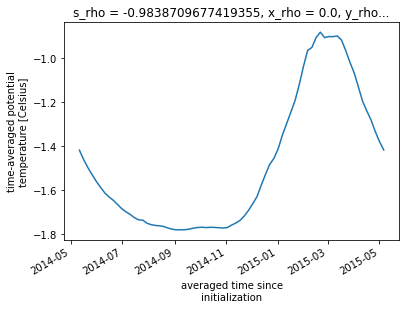

In [14]:
plt.close()
fig,ax = plt.subplots()
temp_shallow_WEA.plot(ax=ax)
plt.show()

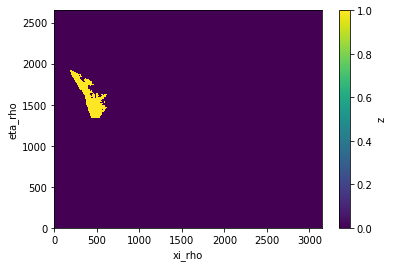

In [73]:
mask = (grd.z >= -300) & (mask_sector_shelf["Bellingshausen Sea"])

plt.close()
mask[30].plot()
plt.show()

In [107]:
mask_sector_shelf.keys()

dict_keys(['Total Antarctica', 'Western East Antarctica', 'Amery/Prydz Bay', 'Sabrina Coast/Aurora subglacial basin', 'George V Coast/Wilkes subglacial basin', 'Ross Sea', 'Amundsen Sea', 'Bellingshausen Sea', 'Weddell Sea'])

In [138]:
sel_dict = {k: mask_sector[k] for k in ['Sabrina Coast/Aurora subglacial basin', 'George V Coast/Wilkes subglacial basin', 'Ross Sea', 'Amundsen Sea', 'Bellingshausen Sea', 'Weddell Sea']}

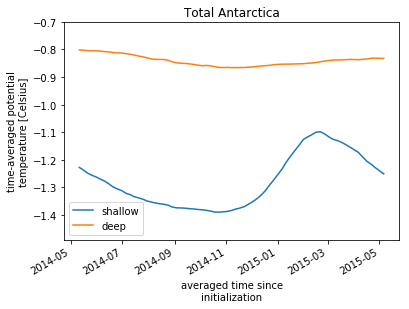

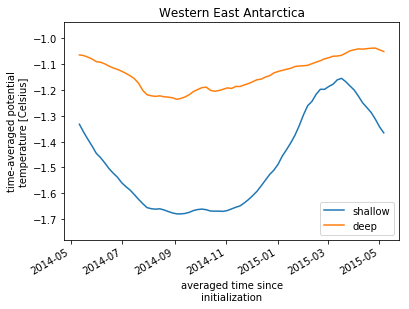

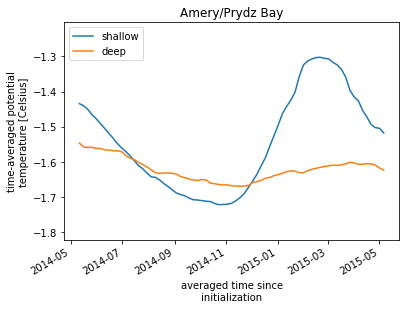

In [127]:
plt.close()
for key,data in shallow_temp.items():
    fig,ax = plt.subplots()
    shallow_temp[key].plot(ax=ax,label='shallow')
    deep_temp[key].plot(ax=ax,label='deep')
    ax.legend()
    y_min = min(deep_temp[key].min(),shallow_temp[key].min())-0.1
    y_max = max(deep_temp[key].max(),shallow_temp[key].max())+0.1
    ax.set_ylim(y_min,y_max)
    ax.set_title(key)
    plt.savefig(os.path.join(fig_dir,'temp_shallow_deep_'+key.replace('/','_')+'_.png'))

In [112]:
xi,eta = np.meshgrid(grd.xi_rho,grd.eta_rho)

In [124]:
grd.xi_rho.where(mask).min()

<xarray.DataArray ()>
array(2569.)

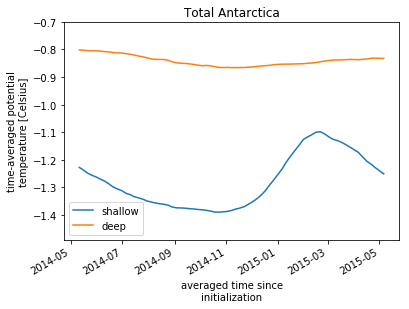

In [88]:
key = 'Total Antarctica'
plt.close()
fig,ax1 = plt.subplots()
#ax1,ax2 = axes.flatten()
y_min = min(deep_temp[key].min(),shallow_temp[key].min())-0.1
y_max = max(deep_temp[key].max(),shallow_temp[key].max())+0.1
ax1.set_ylim(y_min,y_max)
shallow_temp[key].plot(ax=ax1,label='shallow')
deep_temp[key].plot(ax=ax1,label='deep')
ax1.legend()
ax1.set_title(key)
plt.savefig(os.path.join(fig_dir,'temp_shallow_deep_'+key.replace('/','_')+'_.png'))
plt.show()

In [36]:
temp_shallow_WEA

<xarray.DataArray ()>
array(-1.336573)
Coordinates:
    ocean_time  datetime64[ns] 2014-05-11T12:00:00

In [ ]:
mask_shallow = mask_sector['Western East Antarctica'] & (grd.zice > -200)
test_area = grd.mask_rho.where(mask_sector['Western East Antarctica'] & grd.zice > -200))

In [109]:

m_shallow = m.where(shelves['Wilkins']['mask']).mean(['xi_rho','eta_rho'])
m_deep = m.where(shelves['George VI']['mask']).mean(['xi_rho','eta_rho'])

In [128]:
s2a = 365*24*3600
mask_deep_B = ((mask_deep==1) & (mask_sector["Bellingshausen Sea"]))[sel]
mask_shallow_B = ((mask_deep==2) & (mask_sector["Bellingshausen Sea"]))[sel]

m_shallow_B = m[sel].where(mask_shallow_B).mean(['xi_rho','eta_rho'])*s2a
m_deep_B = m[sel].where(mask_deep_B).mean(['xi_rho','eta_rho'])*s2a

In [129]:
m_deep_B

<xarray.DataArray (ocean_time: 73, s_rho: 31)>
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-05-11T12:00:00 ...
Dimensions without coordinates: s_rho

No handles with labels found to put in legend.


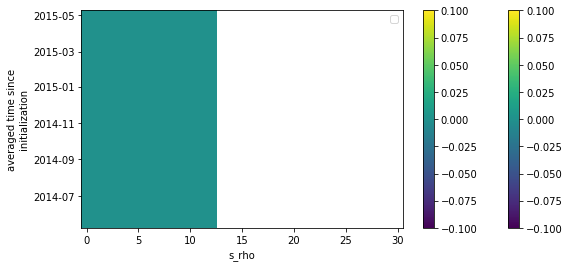

In [130]:
plt.close()
fig,ax = plt.subplots(figsize=(9,4))
(m_shallow_B-m_shallow_B.mean()).plot(ax=ax,label='shallow')
(m_deep_B-m_deep_B.mean()).plot(ax=ax,label='deep')
ax.legend()
plt.show()

In [4]:
mask_shelf = mask_sector_shelf['Total Antarctica']
mask_cavity = grd.zice < 0.0

In [5]:
mask_Bel = mask_shelf & mask_sector['Bellingshausen Sea']

In [20]:
sel = {'xi_rho':slice(0,1000),'eta_rho':slice(1000,2000)}

In [40]:
mask_shallow = mask_Bel & (grd.z > -200)
mask = mask_shallow[sel]
    
dV = grd[sel].dV.where(mask)
weights = dV/dV.sum()

In [46]:
temp_shallow = (temp[sel].where(mask)*weights).sum(['xi_rho','eta_rho','s_rho']).load()

In [72]:
mask_deep = mask_Bel & (grd.z <= -400)

mask = mask_deep[sel]

dV = grd[sel].dV.where(mask)
weights = dV/dV.sum()

temp_deep = (temp[sel].where(mask)*weights).sum(['xi_rho','eta_rho','s_rho']).load()

<IPython.core.display.Javascript object>


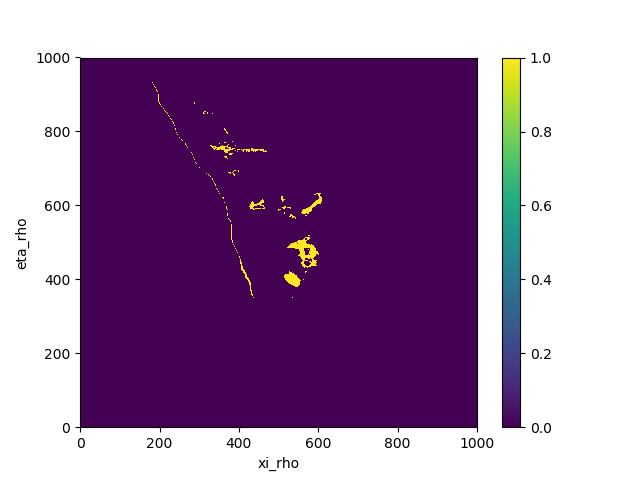

In [71]:
%matplotlib notebook
mask_deep = mask_Bel & (grd.z <= -400)
plt.close()
mask_deep[:,:,10][sel].plot()
plt.show()

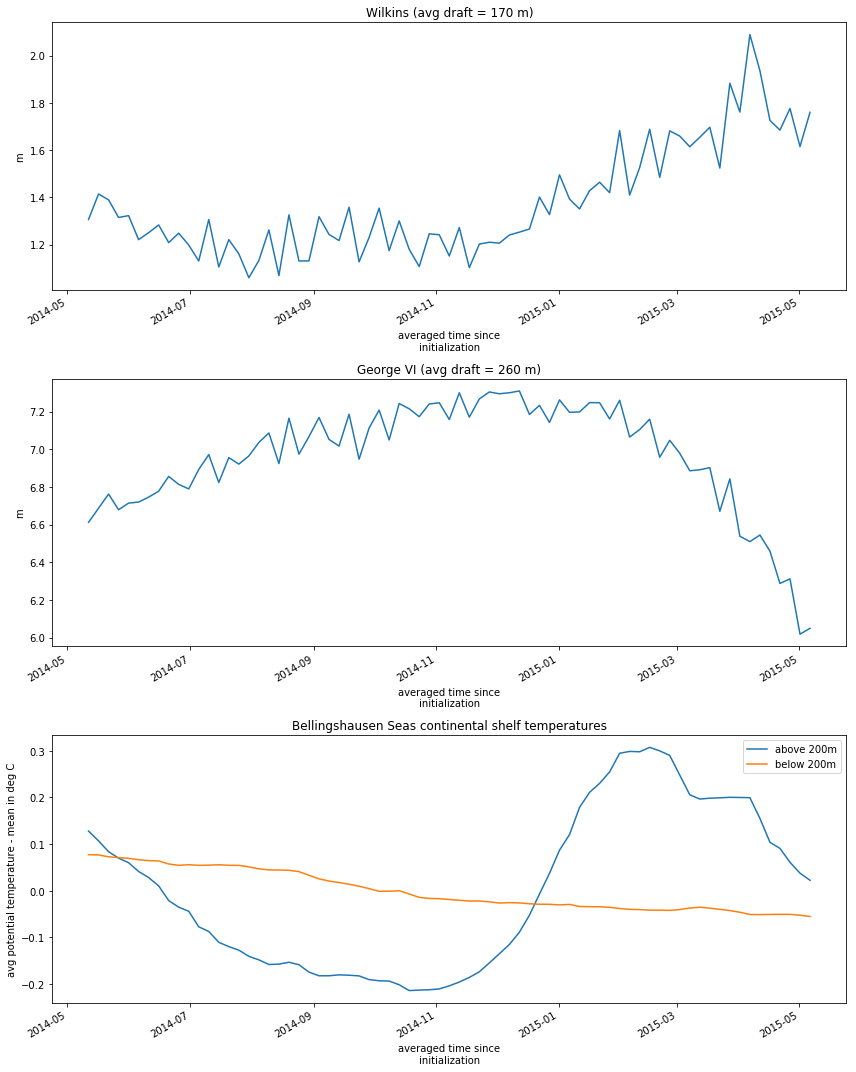

In [103]:
%matplotlib inline
plt.close()
fig,[ax1,ax2,ax3] = plt.subplots(nrows=3,figsize=(12,15))

((m_shallow)*s2a).plot(ax=ax1,label='Wilkins (avg draft = 170 m)')
((m_deep)*s2a).plot(ax=ax2,label='George VI (avg draft = 260 m)')
#ax2.set_ylabel('avg melting - mean in m/yr')
ax1.set_title('Wilkins (avg draft = 170 m)')
ax2.set_title('George VI (avg draft = 260 m)')
#ax1.set_ylim(-1,1)
#ax1.legend()
(temp_shallow-temp_shallow.mean()).plot(ax=ax3,label='above 200m')
(temp_deep-temp_deep.mean()).plot(ax=ax3,label='below 200m')
ax3.set_ylabel('avg potential temperature - mean in deg C')
ax3.set_title('Bellingshausen Seas continental shelf temperatures')
ax3.legend()
plt.tight_layout()
plt.show()

In [77]:
plt.close()

In [38]:
mask_shallow = mask_Bel & (grd.z > -200)
mask = mask_shallow[sel]
    
dV = grd[sel].dV.where(mask)
weights = dV/dV.sum()
temp_shallow = temp.isel(eta_rho=0,xi_rho=0,s_rho=0)
for i,time in log_progress(enumerate(temp.ocean_time),every=2):
    
    temp_shallow[i] = (temp.sel(ocean_time=time)[sel].where(mask)*weights).sum().values*1.0

TypeError: this variable's data is stored in a dask array, which does not support item assignment. To assign to this variable, you must first load it into memory explicitly using the .load() method or accessing its .values attribute.

In [31]:
temp_deep

-64.51050055487393

In [73]:
mask = mask_Bel & (grd.z > -200)
    
dV = grd.dV.where(mask)
weights = dV/dV.sum()

temp_shallow = (temp.where(mask)*weights).sum().values*1.0

MemoryError: 

In [ ]:
 xi_min={}
    xi_max={}
    eta_min={}
    eta_max={}
    
    for gc in ['rho','u','v']:
        xi_min[gc] = grd['xi'+gc].where(mask_shelf).min().values.astype(int)-1
        xi_max[gc] = grd['xi'+gc].where(mask_shelf).max().values.astype(int)+1

        eta_min[gc] = grd['eta'+gc].where(mask_shelf).min().values.astype(int)-1
        eta_max[gc] = grd['eta'+gc].where(mask_shelf).max().values.astype(int)+1

    sel = {'xi_rho':slice(xi_min['rho'],xi_max['rho']),'eta_rho':slice(eta_min,eta_max)}